- with classification
    - classification으로 1,0 구분하는거랑 regression 둘다 만들어두고,
    - classification=1인 경우에 regression 결과값, classification=0인 경우에 0 넣는 방법

# Library Setting

In [1]:
import sys
sys.path.append('/Volumes/KHJ/Github/hyuckjinkim/lib-python')

from base import gc_collect_all, setdiff
from filesystem_utils import mkdir
from graph import abline
from data_prepare import (
    get_holiday, reduce_mem_usage, delete_unique_columns,
    TypeController, CategoricalQuantileCalculator,
    GroupScaler, OneHotEncoder, InteractionTerm, TargetTransform,
)

In [2]:
gc_collect_all()

In [3]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

from tqdm import tqdm
tqdm.pandas()

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('mode.chained_assignment', None)

import datetime

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

In [4]:
def return_unique_columns(data):
    unique_info = data.nunique()
    unique_cols = unique_info[unique_info==1].index.tolist()
    return unique_cols

In [5]:
class CFG:
    SEED = 42
    N_SPLITS = 5
    TARGET = 'price(원/kg)'
    KEY_FEATURES = ['item','corporation','location']
    TARGET_TRANSFORMATION = 'identity'
    SUBSET_DEPTH = 3

<br></br>

# Data

## Data Load

In [6]:
# item:
#     TG : 감귤
#     BC : 브로콜리
#     RD : 무
#     CR : 당근
#     CB : 양배추

In [7]:
train_df = pd.read_csv('./data/train.csv')
test_df  = pd.read_csv('./data/test.csv')
trade_df = pd.read_csv('./data/international_trade.csv')

In [8]:
print(train_df.shape)
train_df.head()

(59397, 7)


,ID,timestamp,item,corporation,location,supply(kg),price(원/kg)
0,TG_A_J_20190101,2019-01-01,TG,A,J,0.0,0.0
1,TG_A_J_20190102,2019-01-02,TG,A,J,0.0,0.0
2,TG_A_J_20190103,2019-01-03,TG,A,J,60601.0,1728.0
3,TG_A_J_20190104,2019-01-04,TG,A,J,25000.0,1408.0
4,TG_A_J_20190105,2019-01-05,TG,A,J,32352.0,1250.0


In [9]:
print(test_df.shape)
test_df.head()

(1092, 5)


,ID,timestamp,item,corporation,location
0,TG_A_J_20230304,2023-03-04,TG,A,J
1,TG_A_J_20230305,2023-03-05,TG,A,J
2,TG_A_J_20230306,2023-03-06,TG,A,J
3,TG_A_J_20230307,2023-03-07,TG,A,J
4,TG_A_J_20230308,2023-03-08,TG,A,J


In [10]:
print(trade_df.shape)
trade_df.head()

(1274, 7)


,기간,품목명,수출 중량,수출 금액,수입 중량,수입 금액,무역수지
0,2019-01,토마토(신선한 것이나 냉장한 것으로 한정한다),356571,990,0,0,990
1,2019-01,양파,821330,222,4003206,1118,-896
2,2019-01,쪽파,60,1,93405,128,-127
3,2019-01,꽃양배추와 브로콜리(broccoli),160,1,638913,563,-562
4,2019-01,방울다다기 양배추,0,0,7580,38,-38


<br>

## Preprocessing

In [11]:
def add_week(weekend):
    week = 1
    week_list = []
    for weekend in weekend:
        if weekend==1:
            week+=1
        week_list.append(week)
    return week_list

In [12]:
def preprocessing(data):
    d = data.copy()
    
    d = d.sort_values(CFG.KEY_FEATURES).reset_index(drop=True)
    
    # (1) datetime format
    d['timestamp'] = d['timestamp'].apply(lambda x: datetime.datetime.strptime(x,'%Y-%m-%d'))
    
    # (2) delete unuse features
    unuse_features = ['ID','supply(kg)']
    unuse_features = list(set(d.columns)&set(unuse_features))
    d.drop(unuse_features,axis=1,inplace=True)

    return d

In [13]:
def merge_trade_data(data,trade_data):
    d, td = data.copy(), trade_data.copy()
    
    ### trade data preprocessing
    
    # # (1) 흑자여부
    td.drop('무역수지',axis=1,inplace=True)

    # (2) 품목명 수정 및 필요없는 품목 정보 제거
    replace_dict = {
        '감귤': 'TG',
        '꽃양배추와 브로콜리(broccoli)': 'BC',
        '당근': 'CR',
        '순무': 'RD',
        '양배추': 'CB',
    }
    td['품목명'] = td['품목명'].map(replace_dict)
    td.dropna(subset=['품목명'], inplace=True)
    
    ### merge data
    d['기간'] = [str(t)[:7] for t in d['timestamp']]
    merged = pd.merge(d,td.rename(columns={'품목명':'item'}),how='left',on=['기간','item'])
    merged.drop('기간',axis=1,inplace=True)
    
    # 2023년 3월 데이터는 trade 데이터에 없으므로 가장 최근의 값으로 채워줌
    merged.ffill(inplace=True)
    
    return merged

In [14]:
def feature_engineering(data):
    d = data.copy()
    
    # (1) date columns
    d['year']       = d.timestamp.dt.year
    d['month']      = d.timestamp.dt.month
    d['day']        = d.timestamp.dt.day
    d['weekday']    = d.timestamp.dt.weekday
    d['weekend']    = d.timestamp.dt.weekday.isin([5,6]).astype(int)
    d['week']       = add_week(d['weekend'])

    # (2) is holiday & is dayoff
    holiday_list = get_holiday(d['year'].unique())
    d['is_holiday'] = d.timestamp.isin(holiday_list).astype(int)
    d['is_dayoff']  = ((d.is_holiday==1) | (d.weekend==1)).astype(int)
    
    # (3) 무역수지, 흑자여부 추가
    d['무역수지'] = d['수출 금액'] - d['수입 금액']
    d['흑자여부'] = np.where(d['무역수지']>0,1,0)
    
    return d

In [15]:
# from copy import deepcopy
# from sklearn.experimental import enable_iterative_imputer
# from sklearn.impute import SimpleImputer, IterativeImputer

# def imputation(train_data,test_data,method):
#     if method in ['mean','median']:
#         base_imputer = SimpleImputer(missing_values=np.nan, strategy=method)
#     elif method=='mice':
#         base_imputer = IterativeImputer(random_state=CFG.SEED)
#     else:
#         raise ValueError(f"Unknown method={method}")
    
#     numerical_cols = train_data.select_dtypes(include=[int,float]).columns.tolist()
#     numerical_cols = list(set(numerical_cols)-set([CFG.TARGET]))
    
#     train_list = []
#     test_list = []
#     for (item,corporation,location),tr in tqdm(train_data.groupby(['item','corporation','location'])):
#         te = test_data[(test_data['item']==item) & (test_data['corporation']==corporation) & (test_data['location']==location)]
#         imputer = deepcopy(base_imputer)
#         tr[numerical_cols] = imputer.fit_transform(tr[numerical_cols])
#         train_list.append(tr)
#         if len(te)>0:
#             te[numerical_cols] = imputer.transform(te[numerical_cols])
#             test_list.append(te)
        
#     new_train = pd.concat(train_list,axis=0)
#     new_test = pd.concat(test_list,axis=0)
    
#     return new_train.sort_index(), new_test.sort_index()

In [16]:
train_df = preprocessing(train_df)
train_df = merge_trade_data(train_df, trade_df)
train_df = feature_engineering(train_df)

test_df = preprocessing(test_df)
test_df = merge_trade_data(test_df, trade_df)
test_df = feature_engineering(test_df)

In [17]:
train_df.head()

,timestamp,item,corporation,location,price(원/kg),수출 중량,수출 금액,수입 중량,수입 금액,year,month,day,weekday,weekend,week,is_holiday,is_dayoff,무역수지,흑자여부
0,2019-01-01,BC,A,J,0.0,160.0,1.0,638913.0,563.0,2019,1,1,1,0,1,1,1,-562.0,0
1,2019-01-02,BC,A,J,0.0,160.0,1.0,638913.0,563.0,2019,1,2,2,0,1,0,0,-562.0,0
2,2019-01-03,BC,A,J,2559.0,160.0,1.0,638913.0,563.0,2019,1,3,3,0,1,0,0,-562.0,0
3,2019-01-04,BC,A,J,2425.0,160.0,1.0,638913.0,563.0,2019,1,4,4,0,1,0,0,-562.0,0
4,2019-01-05,BC,A,J,2097.0,160.0,1.0,638913.0,563.0,2019,1,5,5,1,2,0,1,-562.0,0


<br>

## Target Transformation

In [18]:
target_transform = TargetTransform(func=CFG.TARGET_TRANSFORMATION, offset=1)
train_df[CFG.TARGET] = target_transform.fit_transform(
    target=np.array(train_df[CFG.TARGET]).reshape(-1,1),
)

In [19]:
train_df.head()

,timestamp,item,corporation,location,price(원/kg),수출 중량,수출 금액,수입 중량,수입 금액,year,month,day,weekday,weekend,week,is_holiday,is_dayoff,무역수지,흑자여부
0,2019-01-01,BC,A,J,0.0,160.0,1.0,638913.0,563.0,2019,1,1,1,0,1,1,1,-562.0,0
1,2019-01-02,BC,A,J,0.0,160.0,1.0,638913.0,563.0,2019,1,2,2,0,1,0,0,-562.0,0
2,2019-01-03,BC,A,J,2559.0,160.0,1.0,638913.0,563.0,2019,1,3,3,0,1,0,0,-562.0,0
3,2019-01-04,BC,A,J,2425.0,160.0,1.0,638913.0,563.0,2019,1,4,4,0,1,0,0,-562.0,0
4,2019-01-05,BC,A,J,2097.0,160.0,1.0,638913.0,563.0,2019,1,5,5,1,2,0,1,-562.0,0


<br>

## Quantile values of Target

In [20]:
# feature engineering
calculator = CategoricalQuantileCalculator()
calculator.fit(
    data=train_df,
    test_data=test_df,
    target_feature=CFG.TARGET,
    cat_features=CFG.KEY_FEATURES,
    subset_depth=CFG.SUBSET_DEPTH,
)
train_df = calculator.transform(train_df)
test_df  = calculator.transform(test_df)

> Get quantiles of target by categorical features (depth=3)


Subset: item + corporation + location: 100%|██████| 7/7 [00:00<00:00, 44.53it/s]


<br>

## Group Scaler

In [21]:
# num_features = list(set(train_df.columns)-set(CFG.KEY_FEATURES+['timestamp',CFG.TARGET]))

In [22]:
# from sklearn.preprocessing import MinMaxScaler
# scaler = GroupScaler(scaler=MinMaxScaler())
# scaler.fit(
#     data=train_df,
#     group=CFG.KEY_FEATURES,
#     num_features=num_features,
# )
# train_df = scaler.transform(train_df)
# test_df  = scaler.transform(test_df)

<br>

## Memory Reduce

In [23]:
train_df, _ = reduce_mem_usage(train_df,verbose=False)
test_df , _ = reduce_mem_usage(test_df ,verbose=False)

<br></br>

# EDA

In [24]:
# (1) key별 건수
train_df.groupby(CFG.KEY_FEATURES).size().head()

item  corporation  location
BC    A            J           1523
                   S           1523
      B            J           1523
                   S           1523
      C            J           1523
dtype: int64

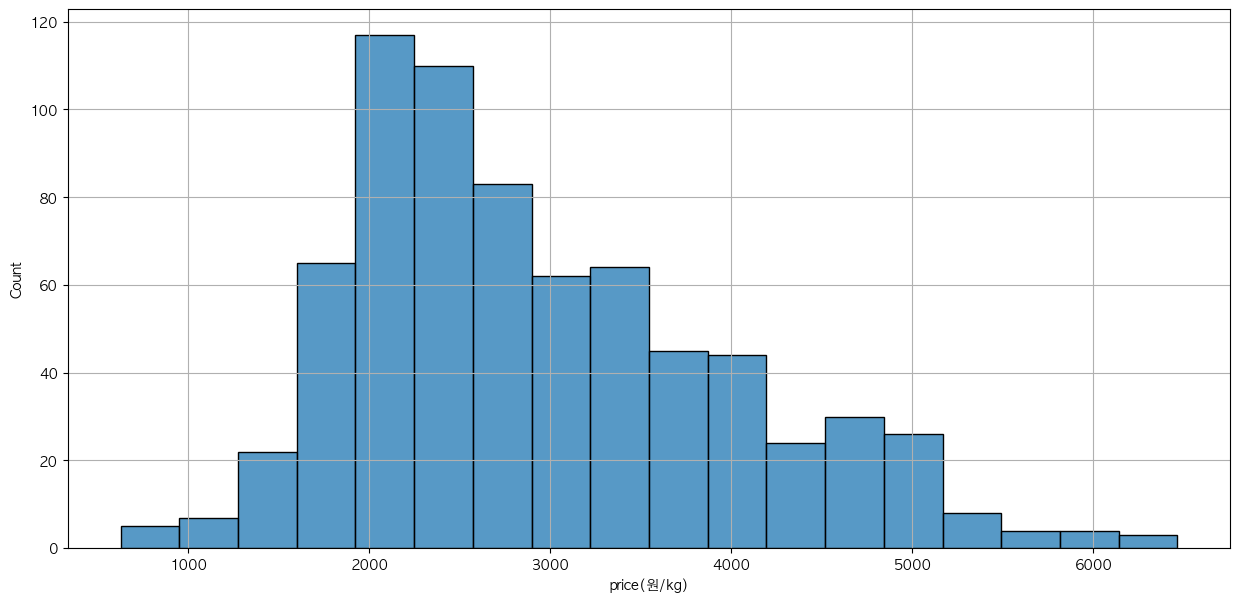

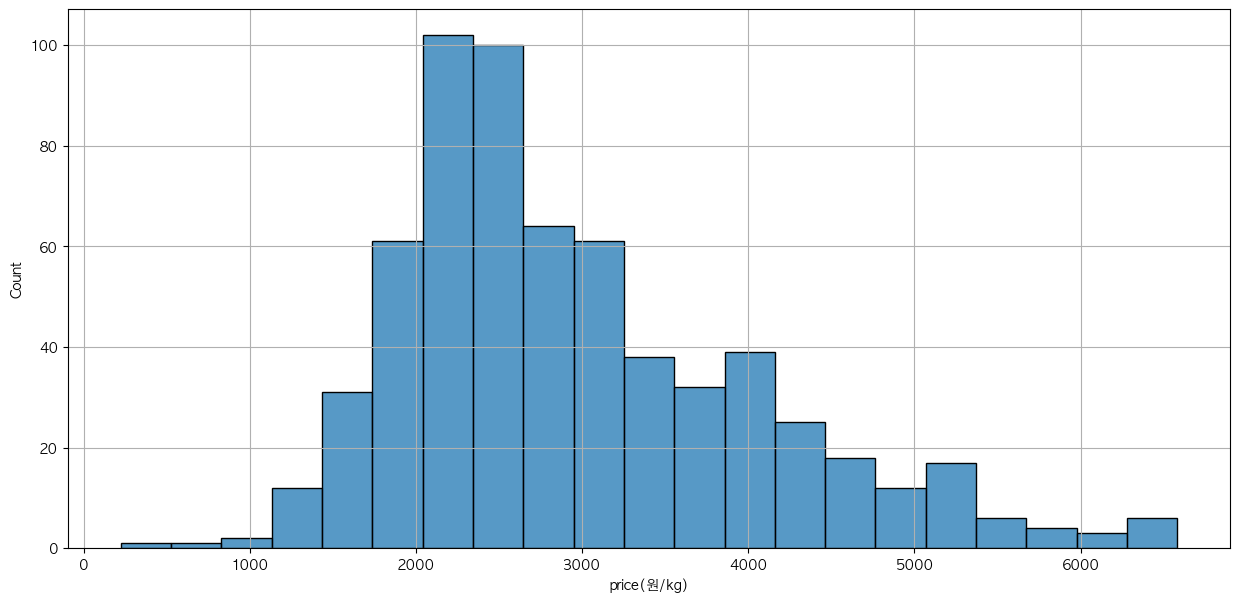

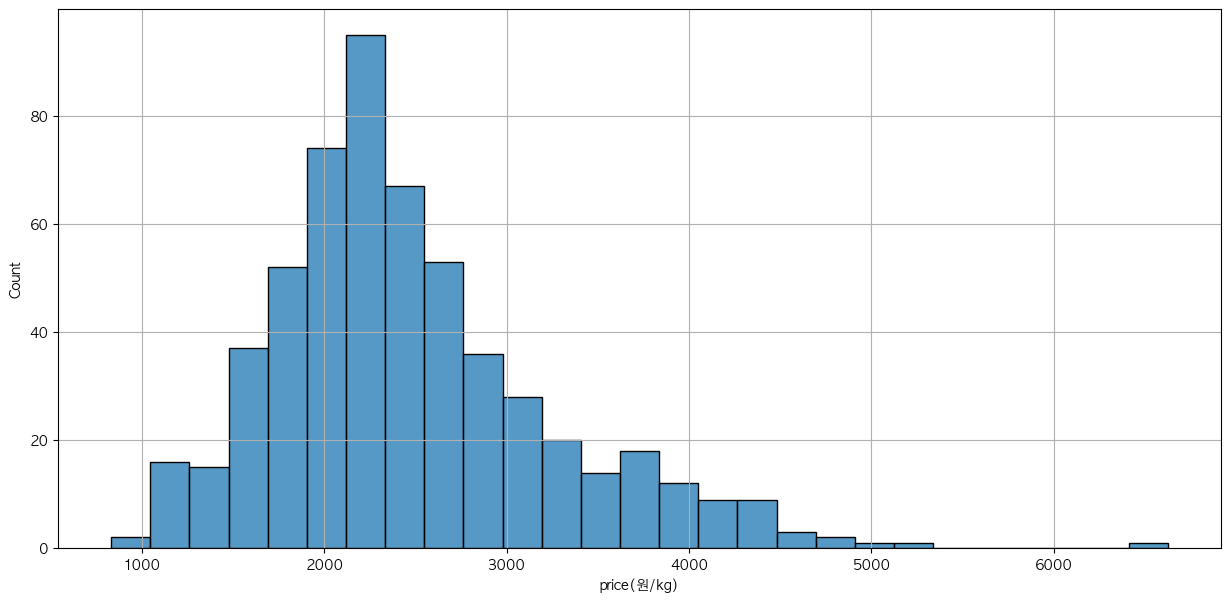

In [25]:
# (2) 품목/법인/지역에 따른 가격 히스토그램
# train_df.groupby(CFG.KEY_FEATURES)[CFG.TARGET].agg(Min=np.min,Max=np.max)
for i,(idx,d) in enumerate(train_df.groupby(CFG.KEY_FEATURES)):
    if i<3:
        target = d[CFG.TARGET]
        target = target[target!=0]
        
        plt.figure(figsize=(15,7))
        sns.histplot(target)
        plt.grid()
        plt.show()

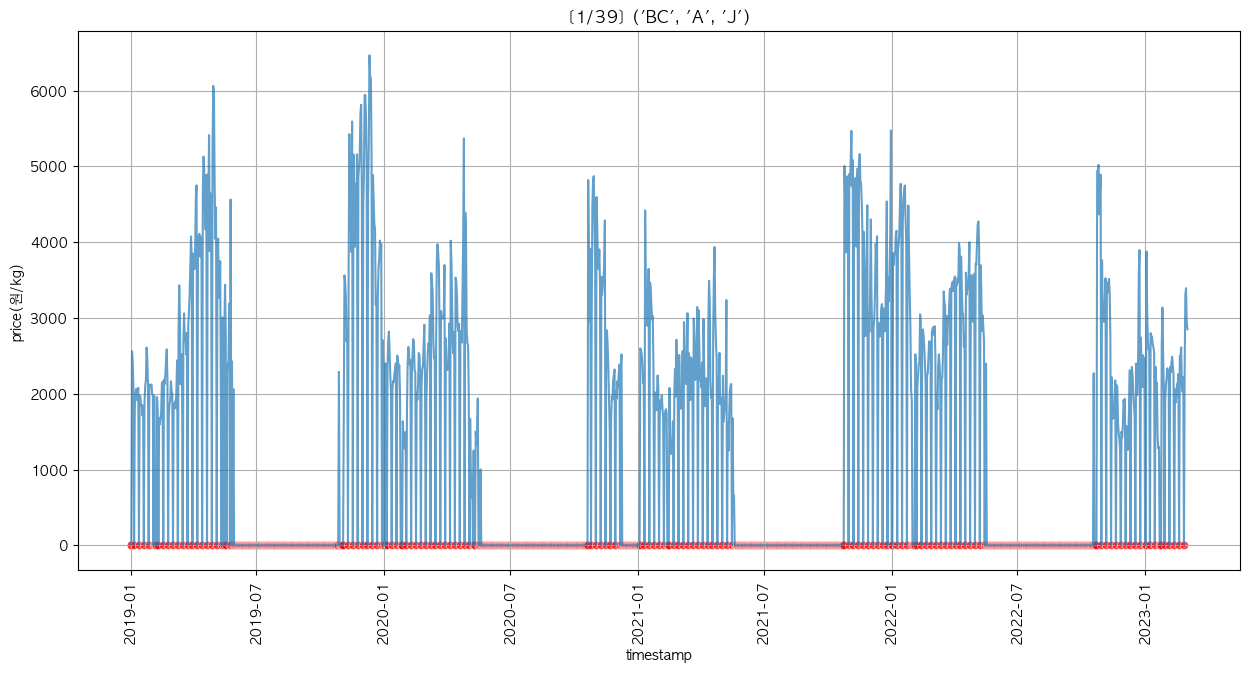

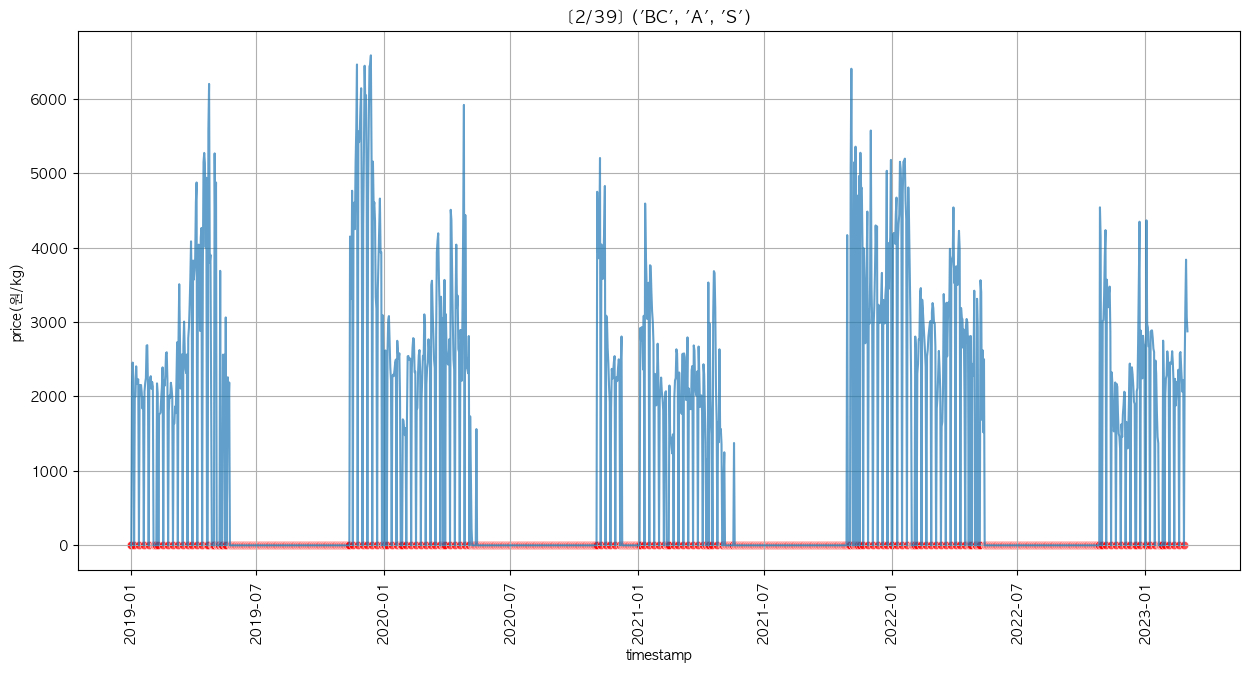

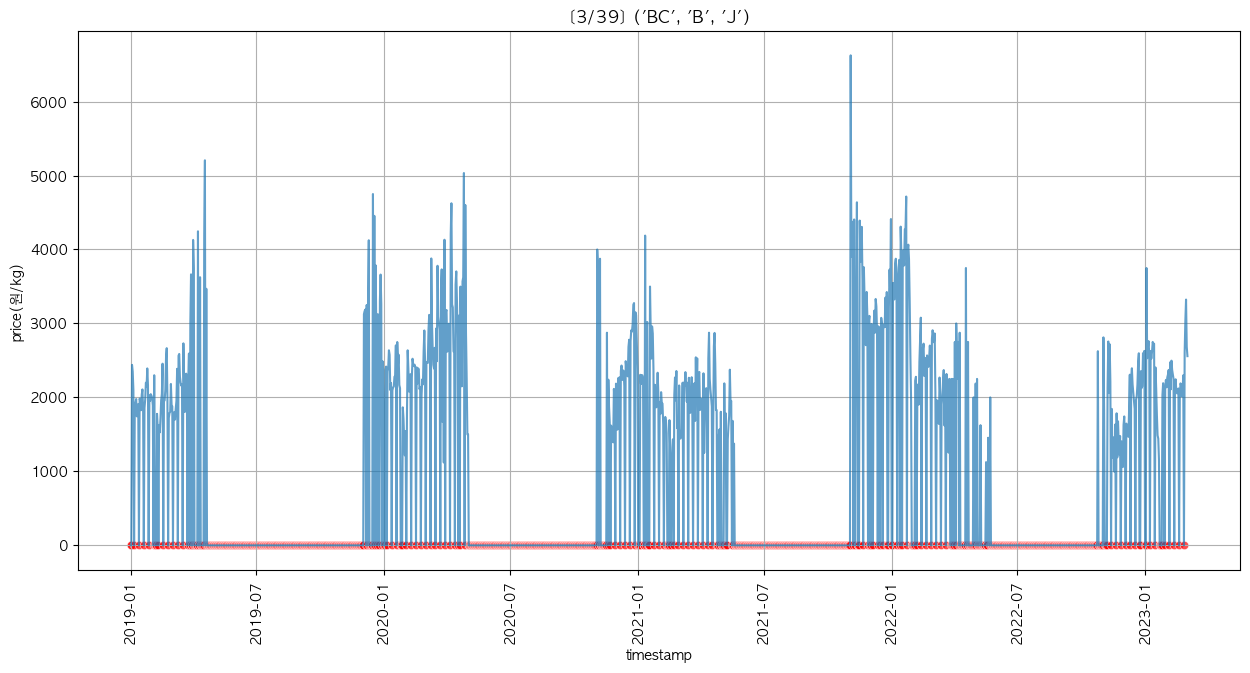

In [26]:
# (3) 품목/법인/지역에 따른 일별 가격변동
grp_data = train_df.groupby(CFG.KEY_FEATURES)
for i,(idx,d) in enumerate(grp_data):
    if i<3:
        plt.figure(figsize=(15,7))
        sns.lineplot(x=d['timestamp'],y=d[CFG.TARGET],alpha=0.7)
        if np.where(d[CFG.TARGET]==0,1,0).sum()>0:
            x=d['timestamp'][d[CFG.TARGET]==0]
            y=d[CFG.TARGET] [d[CFG.TARGET]==0]
            sns.scatterplot(x=x,y=y,color='red',alpha=0.7)
        plt.xticks(rotation=90)
        plt.grid()
        plt.title(f'[{i+1}/{len(grp_data)}] {idx}')
        plt.show()

<br></br>

# Modeling

In [27]:
from sklearn.model_selection import KFold
from autogluon.tabular import TabularDataset, TabularPredictor
from autogluon.core.metrics import make_scorer

/Users/khj/anaconda3/envs/torch_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [28]:
train_data = train_df.copy()
test_data  = test_df .copy()

train_data[CFG.KEY_FEATURES] = train_data[CFG.KEY_FEATURES].astype('category')
test_data[CFG.KEY_FEATURES]  = test_data [CFG.KEY_FEATURES].astype('category')

In [ ]:
kf = KFold(n_splits=CFG.N_SPLITS, shuffle=True, random_state=CFG.SEED)
models = []
k=0
for tr_idx,val_idx in tqdm(kf.split(train_data),total=CFG.N_SPLITS):
    k+=1
    print('='*80)
    print('> KFold: {}/{}'.format(k,CFG.N_SPLITS))
    print('='*80)
    tr_data, val_data = train_data.iloc[tr_idx], train_data.iloc[val_idx]
    
    tr_data  = TabularDataset(tr_data)
    val_data = TabularDataset(val_data)

    model = TabularPredictor(label=CFG.TARGET, eval_metric='rmse')
    model.fit(tr_data, val_data)
    models.append(model)
    # num_bag_folds = 10, num_bag_sets = 10, num_stack_levels = 0, presets='best_quality', time_limit=360000

  0%|                                                     | 0/5 [00:00<?, ?it/s]No path specified. Models will be saved in: "AutogluonModels/ag-20231112_015927/"
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20231112_015927/"
AutoGluon Version:  0.8.2
Python Version:     3.10.13
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 23.0.0: Fri Sep 15 14:41:43 PDT 2023; root:xnu-10002.1.13~1/RELEASE_ARM64_T6000
Disk Space Avail:   1765.10 GB / 2000.20 GB (88.2%)
Train Data Rows:    47517
Train Data Columns: 46
Tuning Data Rows:    11880
Tuning Data Columns: 46
Label Column: price(원/kg)
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == int and many unique label-values observed).
	Label info (max, min, mean, stddev): (20909, 0, 1125.80148, 2024.2719)
	If 'regression' is not the correct problem_type, please manually specify the problem_type paramete

> KFold: 1/5


	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Useless Original Features (Count: 6): ['corporation_Q25', 'corporation_Q50', 'location_Q25', 'location_Q50', 'corporation&location_Q25', 'corporation&location_Q50']
		These features carry no predictive signal and should be manually investigated.
		This is typically a feature which has the same value for all rows.
		These features do not need to be present at inference time.
	Unused Original Features (Count: 3): ['item_Q50', 'location_Avg', 'location_Q75']
		These features were not used to generate any of the output features. Add a feature generator compatible with these features to utilize them.
		Features can also be unused if they carry very little information, such as being categorical but having almost entirely unique values or being duplicates of other features.
		These features do not need to be present at inference time.
		('float', []) : 2 | ['item_Q50'

[1000]	valid_set's rmse: 1052.19


	-1051.7662	 = Validation score   (-root_mean_squared_error)
	10.6s	 = Training   runtime
	0.07s	 = Validation runtime
Fitting model: LightGBM ...


[1000]	valid_set's rmse: 867.507


	-866.4434	 = Validation score   (-root_mean_squared_error)
	13.32s	 = Training   runtime
	0.09s	 = Validation runtime
Fitting model: RandomForestMSE ...
	-893.2492	 = Validation score   (-root_mean_squared_error)
	9.98s	 = Training   runtime
	0.15s	 = Validation runtime
Fitting model: CatBoost ...
	-863.668	 = Validation score   (-root_mean_squared_error)
	37.57s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: ExtraTreesMSE ...
	-893.6036	 = Validation score   (-root_mean_squared_error)
	3.66s	 = Training   runtime
	0.11s	 = Validation runtime
Fitting model: NeuralNetFastAI ...
	-904.8141	 = Validation score   (-root_mean_squared_error)
	34.58s	 = Training   runtime
	0.12s	 = Validation runtime
Fitting model: XGBoost ...
	-867.9422	 = Validation score   (-root_mean_squared_error)
	4.92s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: NeuralNetTorch ...
	-1052.0221	 = Validation score   (-root_mean_squared_error)
	34.12s	 = Training   runtime
	0.03s	

> KFold: 2/5


	Useless Original Features (Count: 6): ['corporation_Q25', 'corporation_Q50', 'location_Q25', 'location_Q50', 'corporation&location_Q25', 'corporation&location_Q50']
		These features carry no predictive signal and should be manually investigated.
		This is typically a feature which has the same value for all rows.
		These features do not need to be present at inference time.
	Unused Original Features (Count: 3): ['item_Q50', 'location_Avg', 'location_Q75']
		These features were not used to generate any of the output features. Add a feature generator compatible with these features to utilize them.
		Features can also be unused if they carry very little information, such as being categorical but having almost entirely unique values or being duplicates of other features.
		These features do not need to be present at inference time.
		('float', []) : 2 | ['item_Q50', 'location_Avg']
		('int', [])   : 1 | ['location_Q75']
	Types of features in original data (raw dtype, special dtypes):
		('

[1000]	valid_set's rmse: 1025.86


	-804.6244	 = Validation score   (-root_mean_squared_error)
	5.68s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: RandomForestMSE ...
	-832.0224	 = Validation score   (-root_mean_squared_error)
	8.72s	 = Training   runtime
	0.1s	 = Validation runtime
Fitting model: CatBoost ...
	-813.6653	 = Validation score   (-root_mean_squared_error)
	54.02s	 = Training   runtime
	0.03s	 = Validation runtime
Fitting model: ExtraTreesMSE ...
	-828.38	 = Validation score   (-root_mean_squared_error)
	3.78s	 = Training   runtime
	0.11s	 = Validation runtime
Fitting model: NeuralNetFastAI ...
	-848.7358	 = Validation score   (-root_mean_squared_error)
	28.21s	 = Training   runtime
	0.06s	 = Validation runtime
Fitting model: XGBoost ...
	-804.6043	 = Validation score   (-root_mean_squared_error)
	4.4s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: NeuralNetTorch ...
	-892.2712	 = Validation score   (-root_mean_squared_error)
	83.42s	 = Training   runtime
	0.03s	 = Va

> KFold: 3/5


	Useless Original Features (Count: 6): ['corporation_Q25', 'corporation_Q50', 'location_Q25', 'location_Q50', 'corporation&location_Q25', 'corporation&location_Q50']
		These features carry no predictive signal and should be manually investigated.
		This is typically a feature which has the same value for all rows.
		These features do not need to be present at inference time.
	Unused Original Features (Count: 3): ['item_Q50', 'location_Avg', 'location_Q75']
		These features were not used to generate any of the output features. Add a feature generator compatible with these features to utilize them.
		Features can also be unused if they carry very little information, such as being categorical but having almost entirely unique values or being duplicates of other features.
		These features do not need to be present at inference time.
		('float', []) : 2 | ['item_Q50', 'location_Avg']
		('int', [])   : 1 | ['location_Q75']
	Types of features in original data (raw dtype, special dtypes):
		('

In [ ]:
submit = pd.read_csv('./data/sample_submission.csv')
submit['answer'] = te_pred_df.pred
submit.to_csv('./out/submit_seg_log.csv',index=False)
submit.head()